In [22]:
import mne
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
from pathlib import Path
from datetime import datetime

In [23]:
# import getpass
# print(getpass.getuser())
# path = '/home/ciprian/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_13/2/ICA'
# print(ica_path)
# save_path = os.path.join(ica_path, "solution_ica.fif")

# print("W", os.access(save_path, os.W_OK))
# print(save_path)
# print(os.path.isdir(ica_path))

### Setup

In [24]:
def find_recordings(path):
    """
    This function makes it easy to find the right recording subdirectories
    """
    subdirs = os.listdir(path)
    for subdir in subdirs:
        # the recording folders have messy names, but they all start with 04
        if "04" in subdir: 
            return subdir
        else:
            continue

In [25]:
old_pp_path = "/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_ANALYZED/PREPROCESSED"   #"/Volumes/BCOM/BCOM/DATA_ANALYZED/PREPROCESSED" #"/home/ciprian/BCOM/BCOM/DATA_ANALYZED/PREPROCESSED"
raw_path = "/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW" #"/Volumes/BCOM/BCOM/DATA_RAW" #"/home/ciprian/BCOM/BCOM/DATA_RAW" 
processed_path = "/pasteur/zeus/projets/p02/BCOM/ciprian_project/data_analyzed/preprocessed" #"/Volumes/BCOM/ciprian_project/data_analyzed/preprocessed" #"/home/ciprian/BCOM/ciprian_project/data_analyzed/preprocessed" #
os.makedirs(processed_path, exist_ok=True)


subjects = [name for name in os.listdir(old_pp_path) if "BCOM" in name] # only the subjects that were deemed good to look at
blocks = [2, 3, 4] # block names
print(subjects)

pdf_suffix = "c,rfDC"
config_suffix = "config"
header_suffix = "hs_file"


# get all of the block recordings            
raw_paths = [os.path.join(raw_path, f"{subject}/MEG/{subject}/BCom/") for subject in subjects]
raw_paths = [os.path.join(raw_path, f"{find_recordings(raw_path)}") for raw_path in raw_paths]
parsed_paths = [os.path.join(raw_path, str(block)) for raw_path in raw_paths for block in blocks]

# just in case
assert len(parsed_paths) == 63
assert all(".DS_Store" not in path for path in parsed_paths)

['BCOM_13', 'BCOM_21', 'BCOM_12', 'BCOM_10', 'BCOM_16', 'BCOM_18', 'BCOM_09', 'BCOM_26', 'BCOM_14', 'BCOM_23', 'BCOM_01', 'BCOM_02', 'BCOM_08', 'BCOM_19', 'BCOM_15', 'BCOM_24', 'BCOM_07', 'BCOM_04', 'BCOM_11', 'BCOM_06', 'BCOM_22']


In [26]:
# get all of the empty room recordings
empty_room_paths = [os.path.join(raw_path, f"{subject}/MEG/{subject}/emp_sup_v1") for subject in subjects]
empty_room_paths = [os.path.join(raw_path, f"{find_recordings(raw_path)}/2") for raw_path in empty_room_paths]

assert len(empty_room_paths) == 21

In [27]:
# some of them are in different folders
empty_room_folder_dict = {
    "BCOM_26" : "4",
    "BCOM_22" : "3",
    "BCOM_21": "1",
    "BCOM_18": "1",
    "BCOM_14": "3" 
}

for i, path in enumerate(empty_room_paths):
    for folder in empty_room_folder_dict:
        if folder in path:
            path = path.rsplit('/', 1)[0] + f"/{empty_room_folder_dict[folder]}"
            print(path)
            empty_room_paths[i] = path

/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_21/MEG/BCOM_21/emp_sup_v1/04%24%19@23_38/1
/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_18/MEG/BCOM_18/emp_sup_v1/04%23%19@23_45/1
/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_26/MEG/BCOM_26/emp_sup_v1/04%26%19@05_56/4
/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_14/MEG/BCOM_14/emp_sup_v1/04%19%19@05_24/3
/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_22/MEG/BCOM_22/emp_sup_v1/04%25%19@03_00/3


In [28]:
# Group together empty rooms and subject blocks so that we can apply the transformations properly
raw_empty_paired = [
    (parsed_paths[i:i+3], empty_room_paths[i // 3]) for i in range(0, len(parsed_paths), 3)
]

# example
print(raw_empty_paired[0])
print("\n")
print(raw_empty_paired[0][0])
print(f"length:{len(raw_empty_paired[0][0])}")
print("\n")
print(raw_empty_paired[0][1])

(['/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/2', '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/3', '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/4'], '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/emp_sup_v1/04%19%19@02_20/2')


['/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/2', '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/3', '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/4']
length:3


/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/emp_sup_v1/04%19%19@02_20/2


In [29]:
# there is no "2" for subject 19, so let's replace it with the other one subject 18 
raw_empty_paired[13] = (raw_empty_paired[13][0], raw_empty_paired[5][1])
raw_empty_paired[13]

(['/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_19/MEG/BCOM_19/BCom/04%24%19@02_37/2',
  '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_19/MEG/BCOM_19/BCom/04%24%19@02_37/3',
  '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_19/MEG/BCOM_19/BCom/04%24%19@02_37/4'],
 '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_18/MEG/BCOM_18/emp_sup_v1/04%23%19@23_45/1')

In [30]:
for i, j in enumerate(raw_empty_paired):
    print(i, j)

0 (['/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/2', '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/3', '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/4'], '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/emp_sup_v1/04%19%19@02_20/2')
1 (['/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_21/MEG/BCOM_21/BCom/04%25%19@00_18/2', '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_21/MEG/BCOM_21/BCom/04%25%19@00_18/3', '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_21/MEG/BCOM_21/BCom/04%25%19@00_18/4'], '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_21/MEG/BCOM_21/emp_sup_v1/04%24%19@23_38/1')
2 (['/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_12/MEG/BCOM_12/BCom/04%19%19@00_21/2', '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_12/MEG/BCOM_12/BCom/04%19%19@00_21/3', '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_12/MEG/BCOM_12/BCom/04%

### Processing setup

In [31]:
# code from Remy
def get_flats(raw, flat_criteria, duration, id, start):
    """
    This function finds and flat channels and returns them as a list
    """
    events_tmp = mne.make_fixed_length_events(raw, duration=duration, id=id, start=start)
    epochs_tmp = mne.Epochs(raw, events=events_tmp, event_id=id, flat=flat_criteria, verbose=False)
    epochs_tmp.load_data()
    
    flat_channels = []
    
    if epochs_tmp.drop_log_stats()>0:
        flat_channels=list(set([ch for chs in epochs_tmp.drop_log for ch in chs]))
    del epochs_tmp

    return flat_channels

def path_parser(path, location: str):
    """
    This function returns the relevant parts of the path
    to make saving things easier
    """
    allowed_locations = ["server", "local", "lab"]
    
    if location not in allowed_locations:
        raise ValueError("location must be one of 'server', 'local', or 'lab'")
    
    if location == "server":
        subject_index = 8
    elif location == "local":
        subject_index = 5
    elif location == "lab":
        subject_index = 6
        
    path = Path(path) 
    
    path_parts = path.parts
    
    subject = path_parts[subject_index] # on home mac this is 5! on lab pc it is 6! on server it is 8
    block = path_parts[-1]
    
    subject_block = os.path.join(subject, block)
    
    return subject_block
    

In [64]:
path_parser(target_raw_empty_paired[0][0][0], location="server")

'BCOM_13/2'

In [62]:

target_raw_empty_paired = []
for i, pair in enumerate(raw_empty_paired):
    if "BCOM_13" in pair[0][0]:
        target_raw_empty_paired.append(pair)
target_raw_empty_paired

# target_subject = "BCOM_13"
# raw_empty_paired_target = raw_empty_paired[0][0][0]

[(['/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/2',
   '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/3',
   '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/4'],
  '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/emp_sup_v1/04%19%19@02_20/2')]

In [66]:
for i, pairs in enumerate(target_raw_empty_paired):
    print(pairs)
    print(i)

(['/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/2', '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/3', '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/BCom/04%19%19@02_50/4'], '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_13/MEG/BCOM_13/emp_sup_v1/04%19%19@02_20/2')
0


In [18]:
# filtering params, from MNE best practices
lowpass_filter = 150.0 #to get freq up to 150
highpass_filter = 0.5
sampling_rate = 500

# detecting flat channels
flat_criteria= dict(mag=1e-13)
duration=3
id=1
start=2

# ICA setup
ica_method = 'fastica'
n_components = 0.97
decim = 3
random_state = 23
reject = dict(mag=2e-11)

# noth filtering freqs
notch_freqs=(50, 100, 150)

# path parsing location - set this based on where you are running the notebook
location = "server"

In [19]:
def write_to_csv(file_path, strings):
    """
    Writes a list of strings to a CSV file, each string in its own column, and adds a timestamp at the end.

    Parameters:
    - file_path: str, path to the CSV file.
    - strings: list of str, strings to write to the file.
    """
    with open(file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        writer.writerow(strings + [timestamp])

# Example usage:
# write_to_csv('output.csv', ['string1', 'string2', 'string3'])

### Start processing

In [20]:
raw_empty_paired_sliced = raw_empty_paired[6:]
raw_empty_paired_sliced

[(['/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_09/MEG/BCOM_09/BCom/04%18%19@00_17/2',
   '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_09/MEG/BCOM_09/BCom/04%18%19@00_17/3',
   '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_09/MEG/BCOM_09/BCom/04%18%19@00_17/4'],
  '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_09/MEG/BCOM_09/emp_sup_v1/04%17%19@23_58/2'),
 (['/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_26/MEG/BCOM_26/BCom/04%26%19@06_25/2',
   '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_26/MEG/BCOM_26/BCom/04%26%19@06_25/3',
   '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_26/MEG/BCOM_26/BCom/04%26%19@06_25/4'],
  '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_26/MEG/BCOM_26/emp_sup_v1/04%26%19@05_56/4'),
 (['/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_14/MEG/BCOM_14/BCom/04%19%19@05_57/2',
   '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_14/MEG/BCOM_14/BCom/04%19%19@05_57/3',
   '/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_14

In [ ]:
offset = 6
raw_empty_paired_sliced = raw_empty_paired[offset:]
for i, pairs in enumerate(raw_empty_paired_sliced): #NB! make sure you change the index when you want to start from a different place
    
    print(len(pairs))
    subject_raw_paths = pairs[0]
    empty_room_path = pairs[1]    

    print(empty_room_path)
    
    empty_room_pdf_name=os.path.join(empty_room_path, pdf_suffix)
    empty_room_config_name=os.path.join(empty_room_path, config_suffix)
    
    empty_room_raw = mne.io.read_raw_bti(
        pdf_fname=empty_room_pdf_name,
        config_fname=empty_room_config_name,
        head_shape_fname=None,
        rename_channels=True,
        sort_by_ch_name=True,
        ecg_ch="ECG",
        eog_ch=("EOGv", "EOGh"),    
        preload=True,
    )
    
    noisy_channels_empty_room = mne.preprocessing.find_bad_channels_lof(
        empty_room_raw
        .copy()
        .pick("meg")
        .filter(1,100) # the idea here is to remove slow drift to keep channels that might be eroneously removed
        )
    
    flat_channels_empty_room = get_flats(
        raw=empty_room_raw,
        flat_criteria=flat_criteria,
        duration=duration,
        id=id,
        start=start
    )
    
    bad_channels_empty_room = noisy_channels_empty_room + flat_channels_empty_room
    
    print(bad_channels_empty_room)
    
    empty_room_raw.info['bads'] = bad_channels_empty_room

    empty_room_raw.notch_filter(freqs=notch_freqs) # check about that weird thing in 46
    
    filtered_empty_room_raw = empty_room_raw.copy().filter(l_freq=highpass_filter, h_freq=lowpass_filter)
    
    resampled_empty_room_raw = filtered_empty_room_raw.resample(sfreq=sampling_rate)
    
    for j, block in enumerate(subject_raw_paths):
        
        # path parsing for saving later
        subject_block = path_parser(block, location=location)
        data_path = os.path.join(processed_path, subject_block)
        ica_path = os.path.join(data_path, "ICA")
        
        for path in [data_path, ica_path]:
            os.makedirs(path, exist_ok=True)
            
        
        # get file names
        subject_pdf_fname=os.path.join(block, pdf_suffix)
        subject_config_fname=os.path.join(block, config_suffix)
        subject_head_shape_fname=os.path.join(block, header_suffix)
        
#         print(empty_room_pdf_name)
#         print(empty_room_config_name)
#         print(subject_pdf_fname)
#         print(subject_config_fname)
#         print(subject_head_shape_fname)
        
        subject_raw = mne.io.read_raw_bti(
            pdf_fname=subject_pdf_fname,
            config_fname=subject_config_fname,
            head_shape_fname=subject_head_shape_fname,
            rename_channels=True,
            sort_by_ch_name=True,
            ecg_ch="ECG",
            eog_ch=("EOGv", "EOGh"),    
            preload=True,
        )
        
        noisy_channels_subject = mne.preprocessing.find_bad_channels_lof(
            subject_raw
            .copy()
            .pick("meg")
            .filter(1,100) # the idea here is to remove slow drift to keep channels that might be eroneously removed
        )
        
        flat_channels_subject = get_flats(
            raw=subject_raw, 
            flat_criteria=flat_criteria,
            duration=duration,
            id=id,
            start=start
        )
        
        bad_channels_subject = noisy_channels_subject + flat_channels_subject
        
        print(bad_channels_subject)

        # get the union of the bads so that the .info['bads'] are the same for both 
        bads_union = list(set(bad_channels_subject).union(set(bad_channels_empty_room)))

        print(bads_union)

        # apply
        subject_raw.info['bads'] = bads_union


        subject_raw.notch_filter(freqs=notch_freqs)
        
        filtered_subject_raw = subject_raw.copy().filter(l_freq=highpass_filter, h_freq=lowpass_filter)
        
        subject_events = mne.find_events(filtered_subject_raw, shortest_event=1)
        
        resampled_subject_raw, resampled_subject_events = filtered_subject_raw.resample(
            sfreq=sampling_rate, 
            events=subject_events
        )
        
        ica_subject = ICA(n_components=n_components, # can use None for better explanation but that takes forever
          method=ica_method,
          random_state=random_state,
          max_iter=2000
        )
        
        # highpass filter at 1 so that the drift doesnt take all the variance - see MNE docs
        subject_raw_ica = resampled_subject_raw.copy().filter(1,None)
        
        ica_subject.fit(
            subject_raw_ica,
            picks='meg',
            decim=decim,
            reject=reject
        ) 
    
        
        # save ICA solution, with the exclude property populated
        subject_ica_path = os.path.join(ica_path, "solution_ica.fif")
        ica_subject.save(subject_ica_path, overwrite=True)
        
#         ica_subject.apply(resampled_subject_raw)
        
        # IMPORTANT! we want a different solution applied each time, so copy in the filtered empty room
        resampled_empty_room_raw_copy = resampled_empty_room_raw.copy()

        # make sure the bads are the same
        resampled_empty_room_raw_copy.info['bads'] = bads_union
        
        # ica_subject.apply(resampled_empty_room_raw_copy) # advised not to apply the solution - can run ICA on it later when we do the covariance calculation
                
        # save the objects
        # NB! note there is no interpolation here. Better to interpolate during the epoching stage
        # since that is analysis based

        resampled_subject_raw_path = os.path.join(data_path, "subject_cleaned_no_ICA_raw.fif")
        resampled_empty_room_raw_copy_path = os.path.join(data_path, "empty_room_cleaned_no_ICA_raw.fif")
        
        # save everything, including the resample events
        resampled_subject_raw.save(resampled_subject_raw_path, overwrite=True)
        resampled_empty_room_raw_copy.save(resampled_empty_room_raw_copy_path, overwrite=True)
        np.save(os.path.join(data_path, "resampled_events.npy"), resampled_subject_events)

        #just in case the 
        print(f"{subject_block} done")
        write_to_csv("/pasteur/zeus/projets/p02/BCOM/ciprian_project/MEG-Decoding/processing_records.csv", [str(i + offset), str(j), str(subject_block)])
        
        del resampled_subject_raw
        del subject_raw_ica
        del resampled_empty_room_raw_copy
    

2
/pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_09/MEG/BCOM_09/emp_sup_v1/04%17%19@23_58/2
Reading 4D PDF file /pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_09/MEG/BCOM_09/emp_sup_v1/04%17%19@23_58/2/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... putting coil transforms in Neuromag coordinates
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Reading 0 ... 366211  =      0.000 ...   180.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.2s


LOF: Detected bad channel(s): []
Using data from preloaded Raw for 59 events and 1425 original time points ...
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rej

/local/scratch/tmp/ipykernel_2298331/842150787.py:8: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs_tmp.load_data()
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 13429 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.9s


Reading 4D PDF file /pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_09/MEG/BCOM_09/BCom/04%18%19@00_17/2/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... putting coil transforms in Neuromag coordinates
... Reading digitization points from /pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_09/MEG/BCOM_09/BCom/04%18%19@00_17/2/hs_file
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Reading 0 ... 1518439  =      0.000 ...   746.341 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- L

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    6.8s


LOF: Detected bad channel(s): []
Using data from preloaded Raw for 248 events and 1425 original time points ...
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Re

    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'ME

/local/scratch/tmp/ipykernel_2298331/842150787.py:8: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs_tmp.load_data()
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.9s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 13429 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s


Trigger channel STI 014 has a non-zero initial value of 512 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1053 events found on stim channel STI 014
Event IDs: [  2   4  12  14  16  22  24  26  32  34  36  42  44  46  52  54  56  62
  64  66 112 114 116 122 124 126 132 134 136 142 144 146 152 154 156 162
 164 166 512 514 516 524 526 528 534 536 538 544 546 548 554 556 558 564
 566 568 574 576 578 624 626 628 634 636 638 644 646 648 654 656 658 664
 666 668 674 676 678]
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.0s


Fitting ICA to data using 246 channels (please be patient, this may take a while)
Selecting by explained variance: 128 components


/pasteur/appa/homes/cbangu/venvs/mne_jupyter/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 1316.3s.
Writing ICA solution to /pasteur/zeus/projets/p02/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_09/2/ICA/solution_ica.fif...
Writing /pasteur/zeus/projets/p02/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_09/2/subject_cleaned_no_ICA_raw.fif
Closing /pasteur/zeus/projets/p02/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_09/2/subject_cleaned_no_ICA_raw.fif
[done]
Writing /pasteur/zeus/projets/p02/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_09/2/empty_room_cleaned_no_ICA_raw.fif
Closing /pasteur/zeus/projets/p02/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_09/2/empty_room_cleaned_no_ICA_raw.fif
[done]
BCOM_09/2 done
Reading 4D PDF file /pasteur/zeus/projets/p02/BCOM/BCOM/DATA_RAW/BCOM_09/MEG/BCOM_09/BCom/04%18%19@00_17/3/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... putting coil transforms in Neuromag coordinates
... Reading digitization points from /pasteur/zeus/projets/p02/BCOM/BCOM/

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    6.2s


LOF: Detected bad channel(s): []
Using data from preloaded Raw for 222 events and 1425 original time points ...
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Re

    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'MEG 173']
    Rejecting flat epoch based on MAG : ['MEG 059', 'ME

/local/scratch/tmp/ipykernel_2298331/842150787.py:8: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs_tmp.load_data()
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    6.6s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 13429 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    6.7s


Trigger channel STI 014 has a non-zero initial value of 512 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1057 events found on stim channel STI 014
Event IDs: [  2   4  12  14  16  22  24  26  32  34  36  42  44  46  52  54  56  62
  64  66 112 114 116 122 124 126 132 134 136 142 144 146 152 154 156 162
 164 166 512 514 516 524 526 528 534 536 538 544 546 548 554 556 558 564
 566 568 574 576 578 624 626 628 634 636 638 644 646 648 654 656 658 664
 666 668 674 676 678]
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.6s


Fitting ICA to data using 246 channels (please be patient, this may take a while)
Selecting by explained variance: 124 components


KeyboardInterrupt: 

Reading /Volumes/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_18/3/ICA/solution_ica.fif ...
Now restoring ICA solution ...
Ready.
<ICA | raw data decomposition, method: fastica (fit in 282 iterations on 131596 samples), 68 ICA components (237 PCA components available), channel types: mag, 3 sources marked for exclusion>


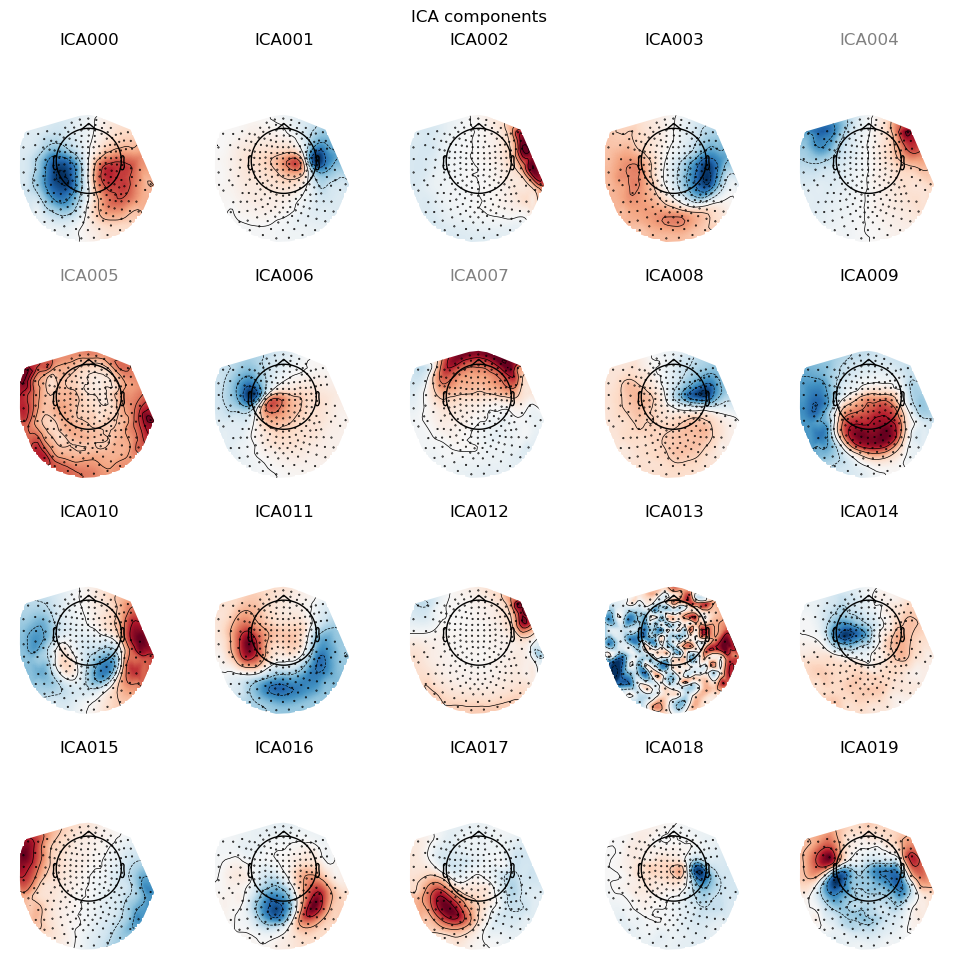

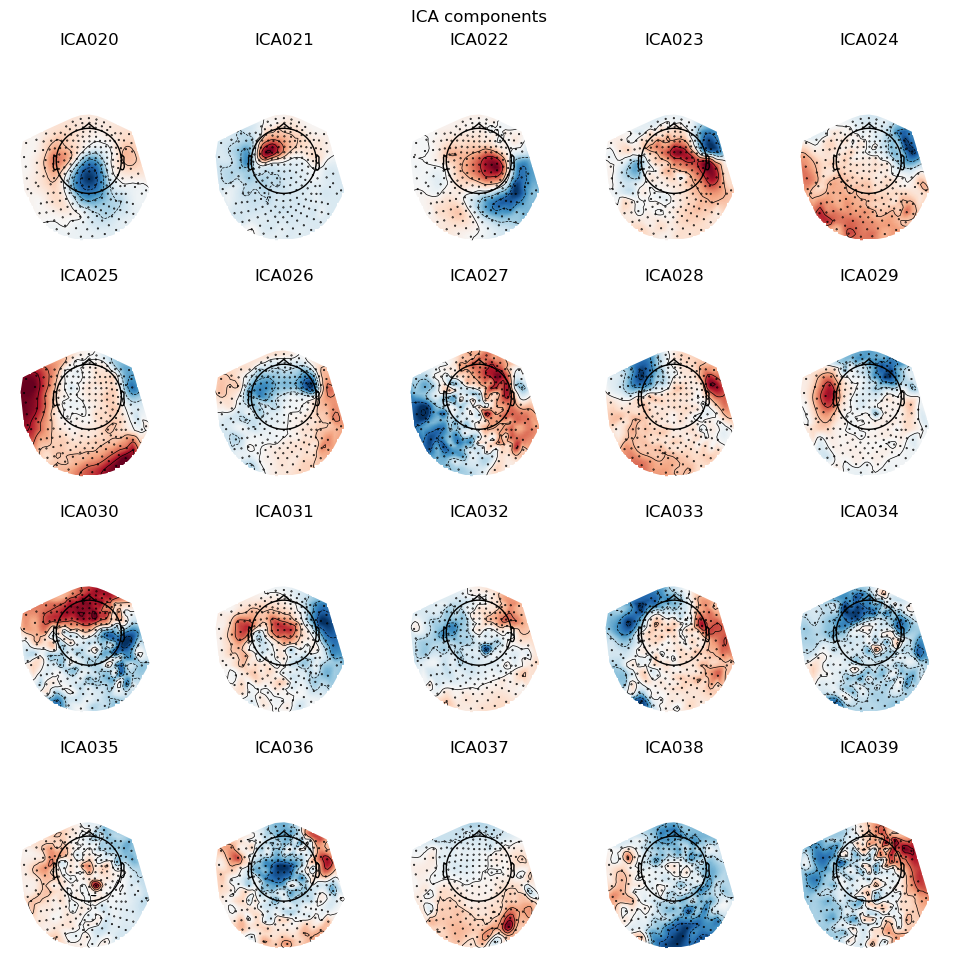

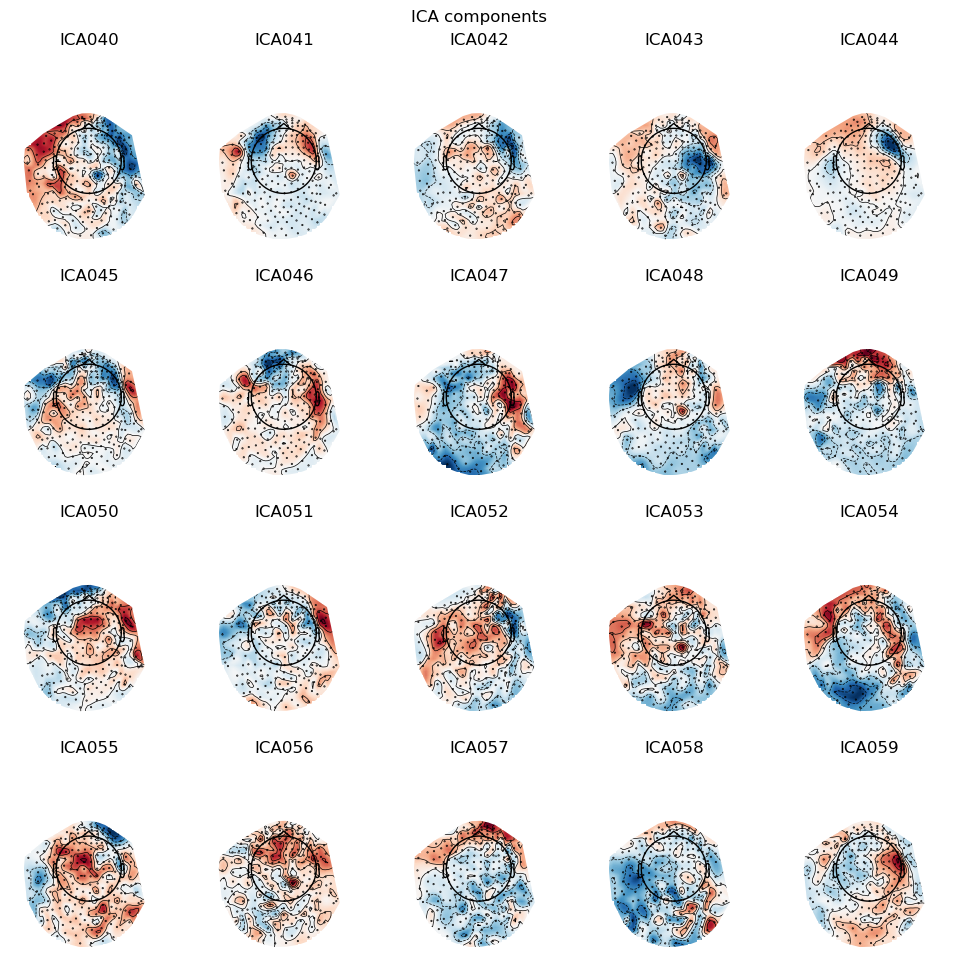

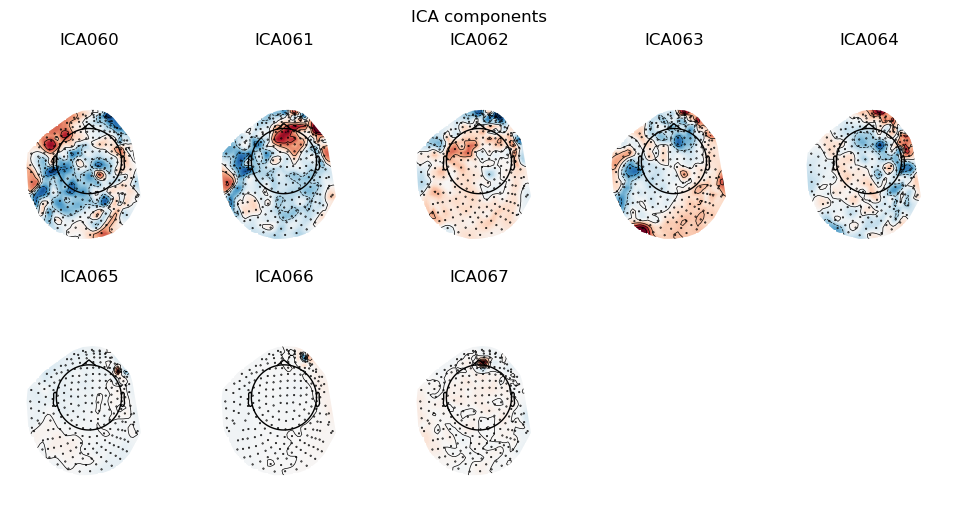

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x496 with 8 Axes>]

In [18]:
from mne.preprocessing import read_ica

# Load the ICA solution
ica_solution_path = "/Volumes/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_18/3/ICA/solution_ica.fif"  # Path to the saved ICA solution
ica_loaded = read_ica(ica_solution_path)

# Print the loaded ICA object to verify
print(ica_loaded)
ica_loaded.plot_components()

